In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [142]:
uni_pats = pd.read_pickle("RawData/Cleaned/patent_university_0711.pkl")
# # Load data
# pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
# print(len(pdf))
# pdf = pdf.drop_duplicates("patent")
# # Remove actual duplicates
# dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
# pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
# print(len(pdf))

uni_pats = uni_pats.merge(pdf[["patent", "appyear", "naics_name", "primclass"]], how = "left", on = "patent")
print(len(uni_pats))
# Drop duplicate patent+university
uni_pats = uni_pats.drop_duplicates(["patent", "organization"])
print(len(uni_pats))

648332
116182


In [116]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["appyear"].apply(get_year_group)
# Drop missing columns
pdf = pdf.dropna(how="any",subset=["appyear", "naics_name", "primclass", "year_group"])
print(len(pdf))

1525486


## 1. Check if university patents show any change around Bayh Dole

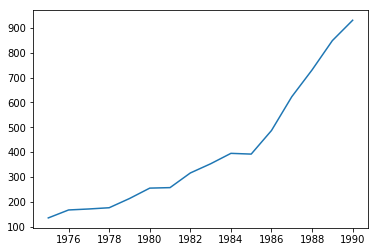

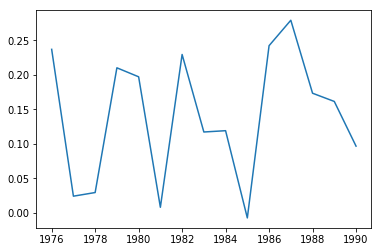

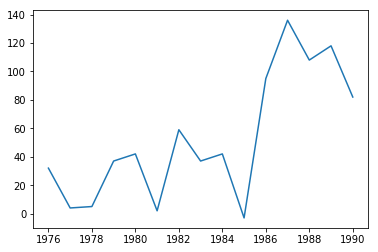

In [155]:
%matplotlib inline
yr_min = 1975
yr_max = 1990
num_u = uni_pats.loc[uni_pats["appyear"].isin(range(yr_min, yr_max+1)), "appyear"].value_counts().sort_index()
num_u_chg = num_u.pct_change()

num_u.plot.line()
plt.show()
num_u_chg.plot.line()
plt.show()
num_u.diff().plot.line()
plt.show()

In [144]:
num_u

1975.0    135
1976.0    167
1977.0    171
1978.0    176
1979.0    213
1980.0    255
1981.0    257
1982.0    316
1983.0    353
1984.0    395
1985.0    392
1986.0    487
1987.0    623
1988.0    731
1989.0    849
Name: appyear, dtype: int64

In [16]:
# Number of total patents in this time period
len(pdf.loc[pdf["appyear"].isin(range(yr_min, yr_max+1)), "appyear"])

459986

## 2. Location measures
### 2.1. Location distributions of new patents at each year

In [146]:
mc = "msaname"
p3 = uni_pats.loc[uni_pats["appyear"].isin(range(yr_min, yr_max+1))]
ploc = p3[[mc, "appyear", "patent"]].groupby([mc, "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.pivot(index="appyear", columns=mc, values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Delete rows that average less than 1%
ploc = ploc[ploc.columns[ploc.apply(lambda x: x.mean()>0.01, axis=0)]]

# Reapply proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

19


In [147]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

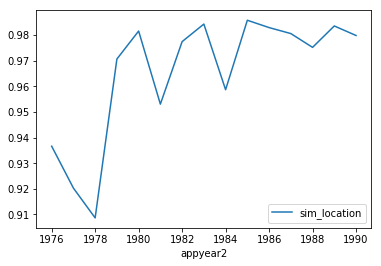

In [148]:
%matplotlib inline
# Plot
sim1 = sim.loc[sim["lag"] == 1, ["appyear2", "sim_location"]].set_index("appyear2")
sim1.plot.line()

In [149]:
act = ploc.loc[[1978,1979]].T
act["Diff"] = act[1979]-act[1978]
act.sort_values("Diff", ascending=False)

appyear,1978,1979,Diff
msaname,,,
"Houston-Sugar Land-Baytown, TX",0.014815,0.058140,0.043325
"New York-Northern New Jersey-Long Island, NY-NJ-PA",0.237037,0.273256,0.036219
"Lexington-Fayette, KY",0.022222,0.034884,0.012661
"Salt Lake City, UT",0.007407,0.017442,0.010034
"Minneapolis-St. Paul-Bloomington, MN-WI",0.044444,0.052326,0.007881
"Tampa-St. Petersburg-Clearwater, FL",0.000000,0.005814,0.005814
"Detroit-Warren-Livonia, MI",0.007407,0.011628,0.004220
"Knoxville, TN",0.007407,0.011628,0.004220
"Chicago-Joliet-Naperville, IL-IN-WI",0.044444,0.046512,0.002067


In [150]:
uni_79 = pd.concat([p3.loc[p3["appyear"] == 1978, "organization"].value_counts(),
                   p3.loc[p3["appyear"] == 1979, "organization"].value_counts()], axis=1)
uni_79.columns = [1978,1979]
uni_79["Diff"] = uni_79[1979]-uni_79[1978]
uni_79.sort_values("Diff", ascending=False)[:10]

,1978,1979,Diff
THE REGENTS OF THE UNIVERSITY OF CALIFORNIA,19.0,34.0,15.0
UNIVERSITY OF DELAWARE,5.0,12.0,7.0
REGENTS OF THE UNIVERSITY OF MINNESOTA,6.0,9.0,3.0
THE TRUSTEES OF BOSTON UNIVERSITY,1.0,4.0,3.0
"IOWA STATE UNIVERSITY RESEARCH FOUNDATION, INC.",10.0,13.0,3.0
UNIVERSITY OF KENTUCKY RESEARCH FOUNDATION,3.0,6.0,3.0
UNIVERSITY OF MIAMI,2.0,4.0,2.0
THE UNIVERSITY OF ILLINOIS FOUNDATION,6.0,8.0,2.0
BOARD OF CONTROL OF MICHIGAN TECHNOLOGICAL UNIVERSITY,3.0,4.0,1.0
UNIVERSITY OF ROCHESTER,5.0,6.0,1.0


### 2.2 HHI

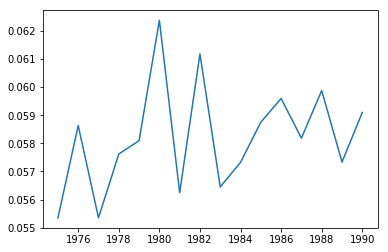

In [115]:
%matplotlib inline
# Plot
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))
hhi.plot.line()

## 2. Bayh-Dole Sample

In [121]:
# Get uni patent industries
uni_naics = uni_pats.loc[uni_pats["appyear"].isin(range(1978,1982)), "naics_name"].value_counts()
uni_naics = uni_naics[uni_naics>100]

In [163]:
c = "naics_name"
k = "year_group"
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
print(c)
print(datetime.datetime.now())
# uni2 = uni_pats.loc[uni_pats["naics_name"].isin(uni_naics.index)]
p2 = pdf.loc[pdf[c].isin(uni_naics.index) & (pdf["appyear"].isin(range(yr_min, yr_max)))]
print(len(p2))
pg = p2.groupby([c,k])
ts = pd.DataFrame()
for n,g in pg:
    s = pd.DataFrame()
    # Get num x existing patent lists and randomize them
    num = 5
    p_all = []
    for i in range(num):
        p_all.extend(g["patent"].tolist())
    # Shuffle
    samp = list(zip(np.random.choice(p_all, size=len(p_all), replace=False),
                  np.random.choice(p_all, size=len(p_all), replace=False)))
    samp = [(i,j) if (i<j)==True else (j,i) for (i,j) in samp]
    s["tp"] = [i[0] for i in samp]
    s["op"] = [i[1] for i in samp]
    ts = ts.append(s, ignore_index = True)
print(len(ts))
    
# Check that target and other do not have same assignee
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp, op in zip(ts["tp"], ts["op"]))
%time asg_match = [len(i) for i in asg_match]

ts["asg_match"] = asg_match
ts = ts.loc[ts["asg_match"] == 0]
ts = ts.drop("asg_match",1)
print(len(ts))

naics_name
2018-07-22 22:30:49.532694
401010
2005050
CPU times: user 67.1 ms, sys: 6.4 ms, total: 73.5 ms
Wall time: 69.7 ms
CPU times: user 2.91 s, sys: 22.2 ms, total: 2.93 s
Wall time: 2.78 s
1994578


In [164]:
print(len(ts.loc[ts["tp"].isin(uni_pats["patent"])]))
print(len(ts.loc[ts["op"].isin(uni_pats["patent"])]))

21168
29994


In [165]:
uni_pats.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_0722.pkl")
ts.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl")